# Zcash Turnstile
A [Noncesense Research Lab](http://www.noncesense.org) study by [Isthmus](https://www.github.com/mitchellpkt) (Mitchell Krawiec-Thayer, Ph.D.)

Modeling ZIP 308 ([Proposal](https://github.com/zcash/zips/pull/197), [Discussion](https://github.com/zcash/zips/pull/197))

```
The amount to send in each transaction is chosen according to the 
following distribution:

1. Choose an integer exponent uniformly in the range 6 to 9 inclusive.
2. Choose an integer mantissa uniformly in the range 1 to 99 inclusive.
3. Calculate amount := (mantissa * 10:sup:`exponent`) zatoshi.
4. If amount is greater than the amount remaining to send, repeat from step 1.
```

## Set Parameters

In [2]:
numSamples = 1000000 # How many samples
numBins = 500

gold = (244/256, 183/256, 40/256)
gray = (76/256,76/256,76/256)

## Import libraries

In [3]:
import random as random
import matplotlib.pyplot as plt
import numpy as np
from pylab import subplot
plt.rcParams.update({'font.size': 15})

In [4]:
%matplotlib inline


## Define functions

In [5]:
# Simulate picking turnstile transaction values 
def sampleDenominations(numSamples, maxExponent=9):
    denominationPicks = []
    for i in range(maxExponent, numSamples):
        exponent = random.randint(6,maxExponent)
        mantissa = random.randint(1,99)
        value = mantissa*10**exponent
        denominationPicks.append(value/10**8)
    return denominationPicks

In [6]:
# Plot the distributions from the simulation
def plotPicks(denominationPicks, maxExponent):
    maxVal = max(denominationPicks)
    
    plt.figure(figsize=(12,12),facecolor='white')

    ax1=subplot(2,1,1)
    plt.hist(denominationPicks, density=1, bins=numBins, color=gray)
    ax1.set_facecolor(gold)
    plt.title('Amount distribution from ZIP 308 with exponents on (6,'+str(maxExponent)+'). Note, log y')
    plt.yscale('log')
    plt.ylabel('Probability');
    plt.xlabel('Amount in ZEC');
    plt.xlim((0,maxVal))
    yl = plt.ylim()
    xl = plt.xlim()
    plt.text(xl[0], 0.8*yl[1],"   Mitchell ~ Isthmus@Noncesense.org")


    ax2=subplot(2,1,2)
    log_bins = 10 ** np.linspace(np.log10(1), np.log10(maxVal), numBins)
    ax2.set_facecolor(gold)
    plt.hist(denominationPicks, density=1, bins=log_bins, color=gray)
    plt.title('Amount distribution from ZIP 308 with exponents on (6,'+str(maxExponent)+'). Note, log y')
    plt.ylabel('Probability');
    plt.xlabel('Amount in ZEC');
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim((0.1,maxVal))
    yl = plt.ylim()
    xl = plt.xlim()
    plt.text(xl[0], 0.75*yl[1],"   Mitchell ~ Isthmus@Noncesense.org")

## Results

### ZIP 308 v1
Written at top, samples exponent on [6,9]

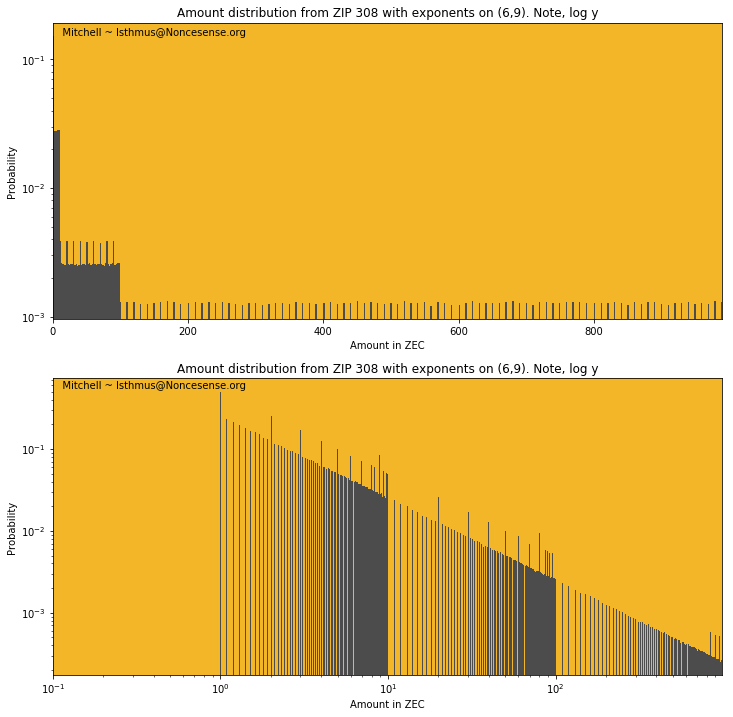

In [7]:
maxExponent = 9
ZIP308v1Picks = sampleDenominations(numSamples, maxExponent)
plotPicks(ZIP308v1Picks, maxExponent)

## Observations:

I’ve been thinking through the outline of “A glimpse through the turnstile: a statistical post-mortem of the Zcash migration” as a mental exercise to think of heuristics that we can take preemptive action to disrupt.

e.g. ToC
- 1 - Introduction
-  2 - Methods
-  2.1 - On-chain data collection
-  2.2 - Metadata collection
-  2.3 - OSINT collection
-  3 - Theory
-  4 - Results
-  4.1 - Estimating number of sprout pool users
-  4.2 - Shielded rich list & the Gini coefficient
-- … etc

**TL;DR: To spoil the analyses in 4.1 and 4.2 I would lean towards reducing the maximum value per turnstile transaction (currently almost 1000 ZEC).**

Regarding 4.1: A big question is “how many individuals had funds in the sprout shielded pool?” The number of turnstile transactions provides an upper bound on that headcount (assuming one person will have multiple transactions, and transactions represent at most one person). Then Number_of_heads <= Number_of_turnstile_txns … Lowering the transaction cap to increase number of transactions per person widens the inequality and makes the upper bound less useful/representative.

Regarding 4.2: Maybe this is a “bug or feature?” situation, but I personally would like to minimize the ability to empirically fit any economic metric (or its bounds)... There is some “real” Gini coefficient in the sprout shielded pool, and the fact that outputs are broken up means that the observed “fractured” Gini coefficient will be a lower bound on the real value. I have a hunch that a turnstile observer might be able to combine known turnstile breakdown rules with the fractured Gini coefficient to probabilistically reconstruct the real Gini coefficient (e.g. Monte Carlo). The more fractured the observed distribution is, harder it is to model the original distribution.

Lowering the maximum turnstile value will add a lot of noise to these heuristics, (also against metadata collection if combined with the practice of connecting to a disjoint set of peers for each turnstile transaction broadcast). Currently the fee is fixed per transaction (to improve fungibility/indistinguishability), so users may object to increasing number of necessary transactions. This could be addressed by fixing the turnstile fee in ZEC/kB, which brings the same fungibility/indistinguishability benefits without incentivizing fewer transactions.

### ZIP 308 v2
Update: maximum exponent was lowered to 8, reducing maximum value to just under 100 ZEC :- )

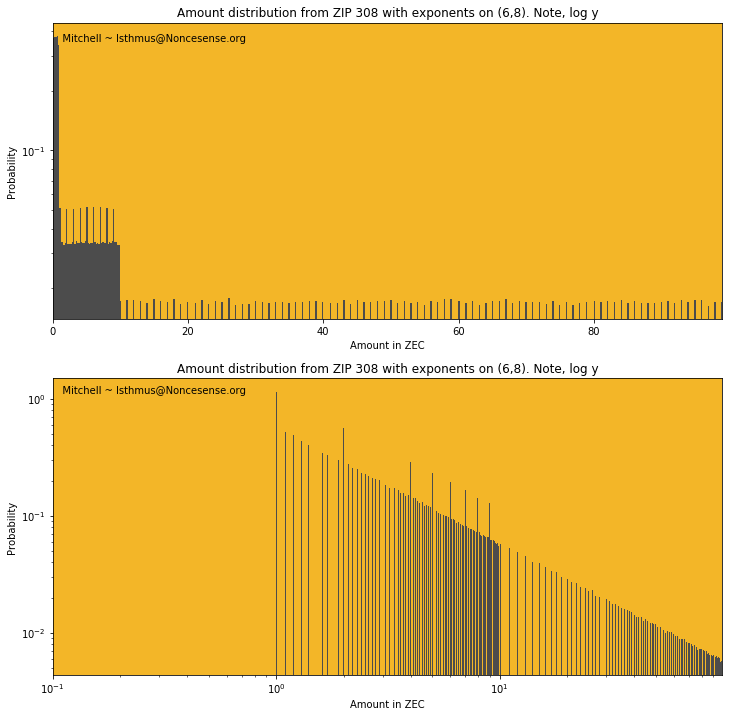

In [8]:
maxExponent = 8
ZIP308v2Picks = sampleDenominations(numSamples, maxExponent)
plotPicks(ZIP308v2Picks, maxExponent)

## Notes


Ranging the mantissa over mode than 1 order of magnitude creates duplicates (e.g. 20x10^6 = 2x10^7) that lead to irregularities in the PDF. Thus there are periodic bins with a greater probability (=anonymity set) than their neighbors on either side.

One could achieve some privacy by using a straghtforward continuous PDF (picture bottom plot with that triangle filled in). Alternately, one could use discrete denominations, e.g. 0.001 ZEC, 0.005 ZEC, etc and that would offer privacy from a different angle

The current algorithm  effectively produces a compromise between the two options. Do they interfere constructively or destructively, with respect to privacy?

I'm still thinking through the optimal properties of the turnstile PDF, with respects to statistical heuristic resistance.